# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [ ]:
#pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.8 MB/s eta 0:00:00


In [17]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Add any additional import statements you need here
from nltk.tokenize import word_tokenize
import string
import emoji
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# change `data_location` to the location of the folder on your machine.
data_location = "/content/drive/MyDrive/USD/SUMMER_2024/Module_6/"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [21]:
# Read in the lyrics data
lyrics_data = pd.DataFrame(columns=['artist', 'song', 'lyrics'])

lyrics_folder_path = os.path.join(data_location, lyrics_folder)

for artist in os.listdir(lyrics_folder_path):
    artist_folder = os.path.join(lyrics_folder_path, artist)
    for song in os.listdir(artist_folder):
        song_file = os.path.join(artist_folder, song)
        with open(song_file, 'r') as file:
            lyrics = file.read()
            new_row = pd.DataFrame({'artist': [artist], 'song': [song], 'lyrics': [lyrics]})
            lyrics_data = pd.concat([lyrics_data, new_row], ignore_index=True)

lyrics_data.head()

,artist,song,lyrics
0,robyn,robyn_bumpyride.txt,"""Bumpy Ride""\n\n\n\nSometimes life can be a bu..."
1,robyn,robyn_inmyheart.txt,"""In My Heart""\n\n\n\nHope things will get bett..."
2,robyn,robyn_youvegotthatsomething.txt,"""You've Got That Something""\n\n\n\nLook at me ..."
3,robyn,robyn_doyouknowwhatittakes.txt,"""Do You Know (What It Takes)""\n\n\n\nDon't you..."
4,robyn,robyn_thelasttime.txt,"""The Last Time""\n\n\n\nEver since I was a litt..."


In [22]:
# Ensure artist_files dictionary is defined
artist_files = {'cher': 'cher_followers_data.txt',
                'robyn': 'robynkonichiwa_followers_data.txt'}

# Read in the twitter data
twitter_data = pd.read_csv(os.path.join(data_location, twitter_folder, artist_files['cher']),
                           sep="\t",
                           quoting=3)
twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(os.path.join(data_location, twitter_folder, artist_files['robyn']),
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([twitter_data, twitter_data_2])

del twitter_data_2
twitter_data.head()


,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [23]:
# Define file paths for positive, negative, and tidytext sentiment words
positive_file_path = os.path.join(data_location, positive_words_file)
negative_file_path = os.path.join(data_location, negative_words_file)
tidytext_file_path = os.path.join(data_location, tidy_text_file)

# Function to read words from a file
def read_words(file_path):
    words = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith(';'):
                words.append(line)
    return words

# Read negative and positive words
negative_words = read_words(negative_file_path)
positive_words = read_words(positive_file_path)

# Initialize lists to store words and their sentiment scores
words = []
scores = []

# Append negative words with a score of -1
words.extend(negative_words)
scores.extend([-1] * len(negative_words))

# Append positive words with a score of 1
words.extend(positive_words)
scores.extend([1] * len(positive_words))

# Read tidy text sentiments
tidytext = pd.read_csv(tidytext_file_path, sep="\t", quoting=3)

# Extract words and their sentiment from the tidytext dataframe
tidytext_words = tidytext['word'].tolist()
tidytext_sentiments = tidytext['sentiment'].tolist()

# Assign scores based on the sentiment column
for word, sentiment in zip(tidytext_words, tidytext_sentiments):
    words.append(word)
    if sentiment == 'positive':
        scores.append(1)
    elif sentiment == 'negative':
        scores.append(-1)

# Create a dataframe to store the words and their scores
sentiment_df = pd.DataFrame({
    'word': words,
    'score': scores
})

# Print the dataframe
sentiment_df.tail()


,word,score
21917,win,1
21918,winner,1
21919,winners,1
21920,winning,1
21921,worthy,1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [26]:
# your code here
# Tokenization function
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Keep only alphabetic tokens
    return tokens

# Sentiment scoring function
def score_sentiment(tokens, sentiment_lexicon):
    score = 0
    for token in tokens:
        if token in sentiment_lexicon:
            score += sentiment_lexicon[token]
    return score

# Create a sentiment lexicon dictionary from sentiment_df
sentiment_lexicon = dict(zip(sentiment_df['word'], sentiment_df['score']))

# Calculate sentiment for each song
lyrics_data['tokens'] = lyrics_data['lyrics'].apply(tokenize)
lyrics_data['sentiment_score'] = lyrics_data['tokens'].apply(lambda tokens: score_sentiment(tokens, sentiment_lexicon))

# Display the DataFrame with sentiment scores
lyrics_data[['artist', 'song', 'sentiment_score']].head()


,artist,song,sentiment_score
0,robyn,robyn_bumpyride.txt,3
1,robyn,robyn_inmyheart.txt,5
2,robyn,robyn_youvegotthatsomething.txt,5
3,robyn,robyn_doyouknowwhatittakes.txt,7
4,robyn,robyn_thelasttime.txt,17


In [27]:
# Calculate average sentiment score for each artist
average_sentiment = lyrics_data.groupby('artist')['sentiment_score'].mean().reset_index()
average_sentiment.columns = ['artist', 'average_sentiment_score']

# Determine the artist with the higher average sentiment score
higher_average_sentiment_artist = average_sentiment.loc[average_sentiment['average_sentiment_score'].idxmax()]

# Display the average sentiment score for each artist and the artist with the highest average sentiment
print("Average sentiment score for each artist:")
print(average_sentiment)
print("\nArtist with the higher average sentiment score:")
print(higher_average_sentiment_artist)


Average sentiment score for each artist:
  artist  average_sentiment_score
0   cher                 6.768987
1  robyn                 9.105769

Artist with the higher average sentiment score:
artist                        robyn
average_sentiment_score    9.105769
Name: 1, dtype: object


In [28]:
# Identify the first artist
first_artist = 'cher'

# Get the top 3 highest and lowest sentiment songs for the first artist
top_3_highest_first_artist = lyrics_data[lyrics_data['artist'] == first_artist].nlargest(3, 'sentiment_score')
top_3_lowest_first_artist = lyrics_data[lyrics_data['artist'] == first_artist].nsmallest(3, 'sentiment_score')

# Display the songs and lyrics
print(f"Top 3 highest sentiment songs for {first_artist}:")
for idx, row in top_3_highest_first_artist.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics: {row['lyrics']}\n")

print(f"Top 3 lowest sentiment songs for {first_artist}:")
for idx, row in top_3_lowest_first_artist.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics: {row['lyrics']}\n")


Top 3 highest sentiment songs for cher:
Song: cher_loveandunderstanding.txt, Sentiment Score: 60
Lyrics: "Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We co

In [29]:
# Identify the second artist
second_artist = 'robyn'

# Get the top 3 highest and lowest sentiment songs for the second artist
top_3_highest_second_artist = lyrics_data[lyrics_data['artist'] == second_artist].nlargest(3, 'sentiment_score')
top_3_lowest_second_artist = lyrics_data[lyrics_data['artist'] == second_artist].nsmallest(3, 'sentiment_score')

# Display the songs and lyrics
print(f"Top 3 highest sentiment songs for {second_artist}:")
for idx, row in top_3_highest_second_artist.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics: {row['lyrics']}\n")

print(f"Top 3 lowest sentiment songs for {second_artist}:")
for idx, row in top_3_lowest_second_artist.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics: {row['lyrics']}\n")


Top 3 highest sentiment songs for robyn:
Song: robyn_loveisfree.txt, Sentiment Score: 127
Lyrics: "Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boo

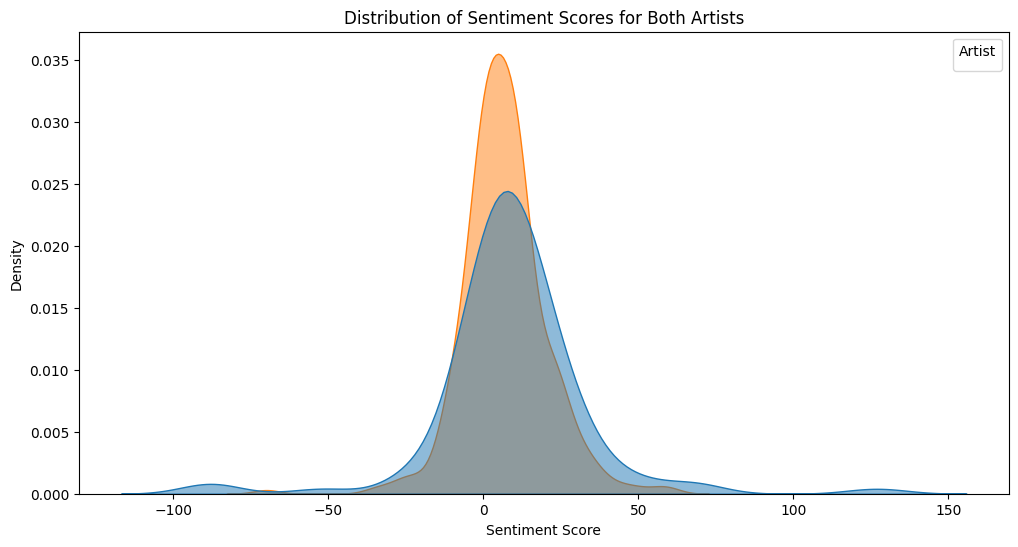

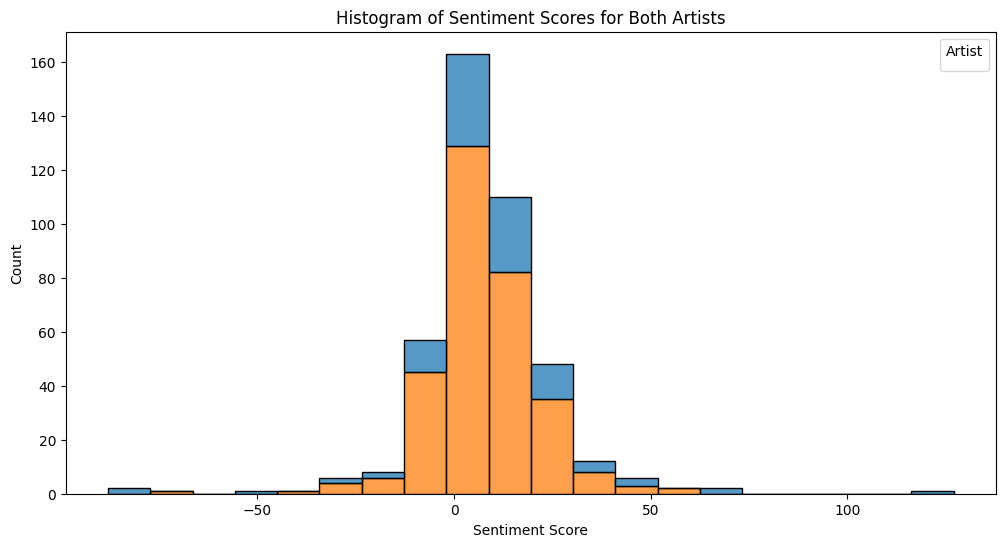

In [33]:


# Plot the distribution of sentiment scores for both artists
plt.figure(figsize=(12, 6))

# Density plot using seaborn
sns.kdeplot(data=lyrics_data, x='sentiment_score', hue='artist', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend(title='Artist')
plt.show()

# Alternatively, plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(data=lyrics_data, x='sentiment_score', hue='artist', multiple='stack', bins=20)
plt.title('Histogram of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(title='Artist')
plt.show()


### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: Robyn has the higher average sentiment per song, with an average sentiment score of 9.11 compared to Cher's 6.77.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: The three highest sentiment songs for Cher are "Love And Understanding," with a sentiment score of 60, "I Found You Love," with a sentiment score of 57, and "Perfection," with a sentiment score of 50. The lyrics of "Love And Understanding" emphasize a need for love and understanding in troubled times, focusing on positive and hopeful themes. In "I Found You Love," the song celebrates finding true and wonderful love filled with happiness and laughter. "Perfection" discusses striving for perfection and realizing that love needs to be genuine and filled with positive aspirations. These positive themes, expressions of love, hope, and personal growth drive the high sentiment scores.

The three lowest sentiment songs for Cher are "Bang-Bang" with a sentiment score of -70, "Bang Bang (My Baby Shot Me Down)" with a sentiment score of -35, and "Outrageous" with a sentiment score of -31. The lyrics of "Bang-Bang" describe a tragic story of being shot by a loved one, filled with sorrow and loss. "Bang Bang (My Baby Shot Me Down)" recounts a painful memory of being shot by a loved one, filled with emotional pain. "Outrageous" is about living boldly and being outrageous, with a hint of rebellion and disregard for others' opinions, which might be driving a negative sentiment. These themes of sorrow, betrayal, emotional pain, and rebellion drive the low sentiment scores.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: The three highest sentiment songs for Robyn are "Love Is Free," with a sentiment score of 127, "We Dance To The Beat," with a sentiment score of 68, and "We Dance To The Beat" (another version), also with a sentiment score of 68. The lyrics of "Love Is Free" emphasize the joy and liberation of love, filled with repeated affirmations of freedom and happiness. "We Dance To The Beat" celebrates dancing and movement, portraying a positive and energetic atmosphere. These positive themes of freedom, joy, and celebration drive the high sentiment scores.
The three lowest sentiment songs for Robyn are "Do not Fucking Tell Me What To Do" with a sentiment score of -88, "Do not Fucking Tell Me What To Do" (another version) also with a sentiment score of -88, and "Criminal Intent" with a sentiment score of -52. The lyrics of "Do not Fucking Tell Me What To Do" repeatedly mention various things that are killing the narrator, filled with frustration and anger. "Criminal Intent" discusses engaging in lewd and indecent acts, portraying a rebellious and defiant attitude. These themes of frustration, anger, and rebellion drive the low sentiment scores.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [36]:
# Define positive and negative emojis
positive_emojis = ['👍', '🎉', '😊', '👏', '💕', '😍', '🤩', '🎊', '👌', '😘']
negative_emojis = ['👎', '😠', '🤕', '😢', '🚫', '😡', '👀', '😤', '🚨', '😩']

# Create a dictionary to map emojis to sentiment scores
emoji_sentiment = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment.update({emoji: -1 for emoji in negative_emojis})

# Function to calculate sentiment score for a Twitter description
def calculate_sentiment(description):
    score = 0
    if isinstance(description, str):  # Check if description is a string
        for emoji in description:
            if emoji in emoji_sentiment:
                score += emoji_sentiment[emoji]
    return score

# Calculate sentiment scores for each artist's followers
artist_sentiments = {}
for artist in twitter_data['artist'].unique():
    descriptions = twitter_data[twitter_data['artist'] == artist]['description']
    sentiment_scores = descriptions.apply(calculate_sentiment)
    artist_sentiments[artist] = sentiment_scores.mean()

# Print average sentiment for each artist
print("Average sentiment for each artist:")
print(artist_sentiments)



Average sentiment for each artist:
{'cher': 0.007753824156034728, 'robyn': 0.003504738093377831}


In [40]:
# Calculate frequency of each emoji for each artist
artist_emoji_freq = {}
for artist in twitter_data['artist'].unique():
    descriptions = twitter_data[twitter_data['artist'] == artist]['description']
    emoji_freq = Counter(emoji for description in descriptions if isinstance(description, str) for emoji in description)
    artist_emoji_freq[artist] = emoji_freq

# Find most popular positive and negative emojis for each artist
for artist, emoji_freq in artist_emoji_freq.items():
    positive_emojis = [emoji for emoji, freq in emoji_freq.items() if emoji in positive_emojis]
    negative_emojis = [emoji for emoji, freq in emoji_freq.items() if emoji in negative_emojis]
    most_popular_positive = max(positive_emojis, key=emoji_freq.get) if positive_emojis else None
    most_popular_negative = max(negative_emojis, key=emoji_freq.get) if negative_emojis else None
    print(f"Most popular positive emoji for {artist}: {most_popular_positive}")
    print(f"Most popular negative emoji for {artist}: {most_popular_negative}")

Most popular positive emoji for cher: 💕
Most popular negative emoji for cher: 🚫
Most popular positive emoji for robyn: 💕
Most popular negative emoji for robyn: 👀


Q: What is the average sentiment of your two artists?

A: Average sentiment for each artist:
{'cher': 0.007753824156034728, 'robyn': 0.003504738093377831}

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: Most popular positive emoji for cher: 💕
Most popular negative emoji for cher: 🚫
Most popular positive emoji for robyn: 💕
Most popular negative emoji for robyn: 👀

